In [1]:
library(devtools)
library(metacell)
load_all("../metacell.flow/")
scdb_init("output/scrna_db/",force_reinit = T)
scfigs_init("figs")
scdb_flow_init()

Loading required package: usethis

i Loading metacell.flow

initializing scdb to output/scrna_db/



In [2]:
mctnetwork_get_type_flows = function(mct, mcf, time, max_time)
{
	net = mct@network
	mc = scdb_mc(mct@mc_id)
    net$flow = mcf@edge_flows

	all_types = unique(mc@colors)[match(mc@color_key$color, unique(mc@colors))]
	mct_mats = list()
	for(t in time:(max_time-1)) {
		f_t = net$time1 == t & net$time2 == t+1 &
					net$type1 != "growth" & net$type2!="growth"

		net_t = net[f_t,] 
		net_t$mc_t1 = mc@colors[as.numeric(net_t$mc1)]
		net_t$mc_t2 = mc@colors[as.numeric(net_t$mc2)]
		flow = as.data.frame(summarize(group_by(net_t, mc_t1, mc_t2),
													tot_flow = sum(flow)))
    
	   mct_mat = pivot_wider(data = flow, 
				names_from = mc_t2, 
				values_from = tot_flow,
				values_fill = list(tot_flow = 0))

	   mct_mat = as.data.frame(mct_mat)
		rownames(mct_mat) = mct_mat$mc_t1
	   mct_mat = mct_mat[,-1]
		max_mc = ncol(mct_mat)
		mct_mat = mct_mat[all_types, all_types]
		mct_mat = as.matrix(mct_mat)
		mct_mats[[t]] = mct_mat
	}

	return(mct_mats)
}

In [3]:
add_alpha = function(col, alpha) {
	return(rgb(t(col2rgb(col))/256, alpha=alpha))
}

draw_sig_edge = function(x1, x2, x2t, y1, y2, y2t, flow, col1, col2, col_alpha=0.8) {
  
	x1 = x1
	y1 = y1
	dx = x2t - x1
	dy = y2t - y1

	y1t = y1+flow
	dxt = x2 - x1
	dyt = y2 - y1t

	col1 = col2rgb(col1)[,1]
	names(col1) = c("red","green","blue")
	col2 = col2rgb(col2)[,1]
	names(col2) = c("red","green","blue")
	res = 0.05
#	message("segs ", "x1 ", x1, " y1 ", y1, " dx ", dx, " dy ", dy, " y1t ", y1t, " dxt ", dxt, " dyt ", dyt)
	beta0 = plogis(0,loc=0.5,scale=0.2)
	beta_f = plogis(1,loc=0.5,scale=0.2)-plogis(0,loc=0.5, scale=0.2)
	for(r in seq(0,0.98,res)) {
			beta = (plogis(r,loc=0.5,scale=0.2)-beta0)/beta_f
			beta5 = (plogis(r+res,loc=0.5,scale=0.2)-beta0)/beta_f

			sx1 = x1+r*dx
			sy1 = y1+beta*dy
			sx2 = x1+(r+res)*dx
			sy2 = y1+beta5*dy

			sx1t = x1+r*dxt
			sy1t = y1t+beta*dyt
			sx2t = x1+(r+res)*dxt
			sy2t = y1t+beta5*dyt
#			r_col = ifelse(grad_col_edge, r,0)
			r_col = r
			rgb_r = col2["red"]*r_col+col1["red"]*(1-r_col)
			rgb_g = col2["green"]*r_col+col1["green"]*(1-r_col)
			rgb_b = col2["blue"]*r_col+col1["blue"]*(1-r_col)
			col = rgb(rgb_r/256, rgb_g/256, rgb_b/256, col_alpha)
			polygon(c(sx1, sx2, sx2t,sx1t), c(sy1, sy2, sy2t, sy1t), col=col, border=NA)
	}
#		segments(x1,y1,x2,y2, 
}

plot_focals = function(fig_dir,plot_pdf = F,bg = "white",focals = c("Early nascent mesoderm", "Late nascent mesoderm", "Epiblast", "Primitive streak")) {
  
  #fig_dir = "figs/paper_figs/fig4/focal_flows"
  
  if(!dir.exists(fig_dir)) {
    dir.create(fig_dir)
  }
  
  mc = scdb_mc("oc_emb")
  
  mat = scdb_mat("oc_emb")
  
  md = mat@cell_metadata
  
  type_ag= table(mc@colors[mc@mc], md[names(mc@mc),"age_group"])
  
  type_agn = t(t(type_ag)/colSums(type_ag))
  
  mct = scdb_mctnetwork("oc_embflow")
  mcf = scdb_mctnetflow("oc_embflow")
  type_flow = mctnetwork_get_type_flows(mct, mcf, 1,13)
  
  
  key = mc@color_key
  rownames(key) = key$group
#   rownames(key) = key$cell_type
  

  t1 = 1
  t2 = 12
  T_minflow_for_type = 0.005
  
  #focals = c("Epiblast", "Early nascent mesoderm", "Late nascent mesoderm", "Primitive streak")
  #focals = c("Late nascent mesoderm")
  
  
  foc_colors = key[focals,"color"]
  for(foc_type in focals) {
    
    foc_color = key[foc_type,"color"]
    cols = names(which(colSums(do.call("rbind", lapply(type_flow, function(x) x[foc_color,])))>T_minflow_for_type))
    foc_agn = type_agn[cols,t1:t2]
    
    base_y = c(1)
    
    for(i in 2:length(cols)) {
      base_y[i] = base_y[i-1] + 0.2 + max(foc_agn[cols[i],]+foc_agn[cols[i-1],])
    }
    names(base_y) = cols
    
    if(plot_pdf) {
      pdf(sprintf("%s/%s.pdf",fig_dir, foc_type),w=30,h=20,useDingbats = F)
    } else {
      png(sprintf("%s/%s.png",fig_dir, foc_type),w=3000,h=2000,bg = bg)
    }
    
    plot(0, xlim=c(t1 - 0.5,t2), ylim=c(min(base_y)-0.5, max(base_y)+0.5),yaxt = 'n',bg = "transparent")
    
    x_pos = 0.5
    y_c =  base_y[foc_color]
    
    segments(x0 = x_pos,x1 = x_pos, y0 = y_c - 0.25,y1 = y_c + 0.25,lwd = 4)
    segments(x0 = x_pos - 0.05,x1 = x_pos + 0.05, y0 = y_c - 0.25,y1 = y_c - 0.25,lwd = 4)
    segments(x0 = x_pos - 0.05,x1 = x_pos + 0.05, y0 = y_c + 0.25,y1 = y_c + 0.25,lwd = 4)
    
    text(x = x_pos - 0.2,y = y_c, labels = "25%",cex = 2)
    smoo_y = list()
    for(c in cols) {
      x = t1:t2
      y = foc_agn[c,t1:t2]
      ys = approx(x,y, seq(t1,t2,l=1+(t2-t1)*100))
      lo = loess(ys$y ~ ys$x,span=0.3)$fitted
      base = base_y[c]
      smoo_y[[c]] = lo
      names(smoo_y[[c]]) = ys$x 
      calpha = add_alpha(c,0.8)
      polygon(c(ys$x,rev(ys$x)), base+c(lo, rev(-lo)), border=NA, col=ifelse(c==foc_color, c, calpha))
    }
    
    foc_i = which(cols == foc_color)
    base_foc = base_y[foc_color]
    for(t in t1:(t2-1)) {
      flow = type_flow[[t]]
      max_i = length(cols)
      cum_y = -smoo_y[[foc_color]][as.character(t)]
      for(i in 1:(foc_i-1)) {
        col_i = cols[i]
        fl = flow[foc_color,col_i]*2
        if(fl > 0) {
          calpha = add_alpha(col_i, 0.8)
          draw_sig_edge(x1=t, x2 = t+1, x2t = t+1-2*fl-0.05, 
                        y1 = base_foc+cum_y,
                        y2 = base_y[col_i]+smoo_y[[col_i]][as.character(t+1)], 
                        y2t =base_y[col_i]+smoo_y[[col_i]][as.character(round(t+1-2*fl-0.05,2))],
                        flow = fl,
                        col1=foc_color, col2=col_i)
          cum_y = cum_y+fl
        }
      }
      cum_y = smoo_y[[foc_color]][as.character(t)]
      for(i in max_i:(foc_i+1)) {
        col_i = cols[i]
        fl = flow[foc_color,col_i]*2
        if(fl > 0) {
          calpha = add_alpha(col_i, 0.8)
          #message("at ", i, " fl ", fl)
          draw_sig_edge(x1=t, x2t = t+1, x2 = t+1-2*fl-0.05, 
                        y1 = base_foc+cum_y-fl,
                        y2t = base_y[col_i]-smoo_y[[col_i]][as.character(t+1)], 
                        y2 =base_y[col_i]-smoo_y[[col_i]][as.character(round(t+1-2*fl-0.05,2))],
                        flow = fl,
                        col1=foc_color, col2=col_i)
          cum_y = cum_y-fl
        }
      }
      #incoming
    }
    dev.off()
  }
  
  
}

In [ ]:
# plot_focals("figs")

In [4]:
fig_dir = "figs"
plot_pdf = T
bg = "white"
# focals = c("Early nascent mesoderm", "Late nascent mesoderm", "Epiblast", "Primitive streak")
# focals = c("Primitive streak")
focals = c("epiblast")
# focals = c("nascent mesoderm")

mc = scdb_mc("oc_emb")

mat = scdb_mat("oc_emb")

md = mat@cell_metadata

type_ag = table(mc@colors[mc@mc], md[names(mc@mc),"chunk"])

type_agn = t(t(type_ag)/colSums(type_ag))

In [5]:
mct = scdb_mctnetwork("oc_embflow_test10")
mcf = scdb_mctnetflow("oc_embflow_test10")

In [6]:
type_flow = mctnetwork_get_type_flows(mct,mcf, 1,12)

`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_t1'. You can override using the
`.groups

In [9]:
foc_color = "#FACB12"
cols = names(which(colSums(do.call("rbind", lapply(type_flow, function(x) x[foc_color,])))>T_minflow_for_type))

In [10]:
c = c()
for(i in 2:11){
c = c(c,sum(type_flow[[i]]["#FACB12","#FACB12"])/sum(type_flow[[i]][,"#FACB12"]))
    }

In [11]:
c

[1] 0.00000000 0.05182535 0.63557959 1.00000000 1.00000000 1.00000000
 [7] 1.00000000 1.00000000 1.00000000 1.00000000

In [12]:
oc_times = fread("oc_embs_grouping.txt")[c("chunk", "gt")] %>% group_by(chunk) %>% summarise(developmental_time = mean(gt)) %>% rename(age_group=chunk)

In [13]:
names(c) = oc_times$developmental_time[2:11]

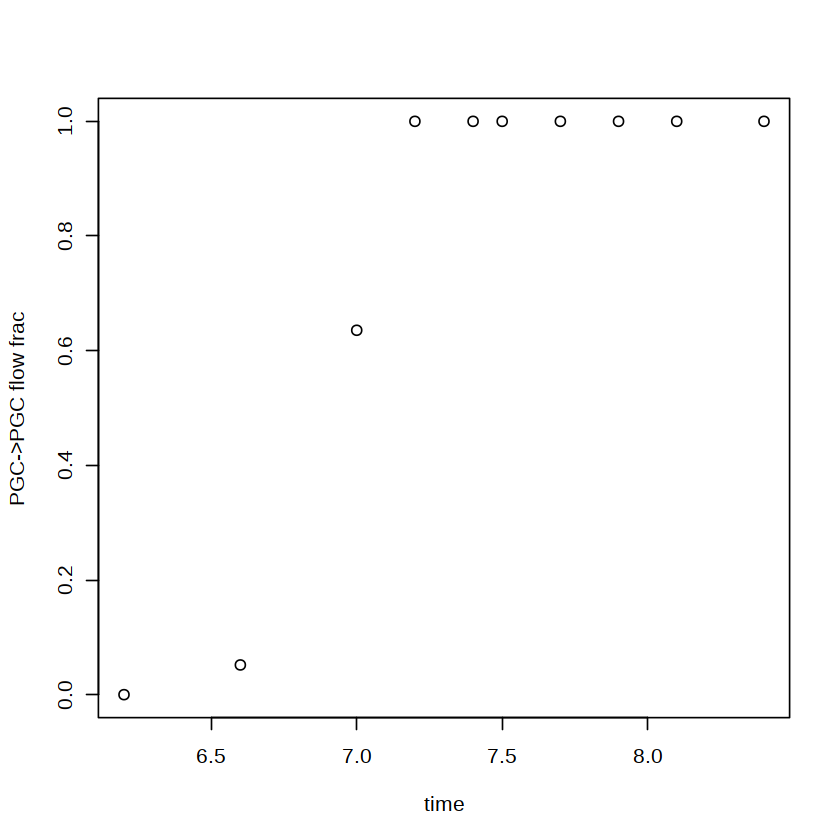

In [14]:
plot(names(c), c, xlab="time", ylab = "PGC->PGC flow frac")

In [15]:
colSums(type_flow[[2]])["#FACB12"]
colSums(type_flow[[3]])["#FACB12"]
colSums(type_flow[[4]])["#FACB12"]
colSums(type_flow[[5]])["#FACB12"]
colSums(type_flow[[6]])["#FACB12"]
colSums(type_flow[[7]])["#FACB12"]

#FACB12 
0.0006042296

#FACB12 
0.009710551

#FACB12 
0.01377534

#FACB12 
0.01122659

#FACB12 
0.01002496

#FACB12 
0.008126984

In [8]:
key = mc@color_key
rownames(key) = key$cell_type

t1 = 1
t2 = 12
T_minflow_for_type = 0.05

#focals = c("Epiblast", "Early nascent mesoderm", "Late nascent mesoderm", "Primitive streak")
#focals = c("Late nascent mesoderm")

In [16]:
cols

[1] "#FACB12"

In [17]:
foc_colors = key[focals,"color"]
for(foc_type in focals) {

    foc_color = key[foc_type,"color"]
    cols = names(which(colSums(do.call("rbind", lapply(type_flow, function(x) x[foc_color,])))>T_minflow_for_type))
#     cols = c('#C594BF','#9e6762','#DABE99','#c19f70')  # reordered_cols
    foc_agn = type_agn[cols,t1:t2]

    base_y = c(1)
    for(i in 2:length(cols)) {
      base_y[i] = base_y[i-1] + 0.2 + max(foc_agn[cols[i],]+foc_agn[cols[i-1],])
    }
    names(base_y) = cols

    if(plot_pdf) {
      pdf(sprintf("%s/%s.pdf",fig_dir, foc_type),w=30,h=20,useDingbats = F)
    } else {
      png(sprintf("%s/%s.png",fig_dir, foc_type),w=3000,h=2000,bg = bg)
    }

    plot(0, xlim=c(t1 - 0.5,t2), ylim=c(min(base_y)-0.5, max(base_y)+0.5),yaxt = 'n',bg = "transparent")

    x_pos = 0.5
    y_c =  base_y[foc_color]

    segments(x0 = x_pos,x1 = x_pos, y0 = y_c - 0.25,y1 = y_c + 0.25,lwd = 4)
    segments(x0 = x_pos - 0.05,x1 = x_pos + 0.05, y0 = y_c - 0.25,y1 = y_c - 0.25,lwd = 4)
    segments(x0 = x_pos - 0.05,x1 = x_pos + 0.05, y0 = y_c + 0.25,y1 = y_c + 0.25,lwd = 4)

    text(x = x_pos - 0.2,y = y_c, labels = "25%",cex = 2)
    smoo_y = list()
    for(c in cols) {
      x = t1:t2
      y = foc_agn[c,t1:t2]
      ys = approx(x,y, seq(t1,t2,l=1+(t2-t1)*100))
      lo = loess(ys$y ~ ys$x,span=0.3)$fitted
      base = base_y[c]
      smoo_y[[c]] = lo
      names(smoo_y[[c]]) = ys$x 
      calpha = add_alpha(c,0.8)
      polygon(c(ys$x,rev(ys$x)), base+c(lo, rev(-lo)), border=NA, col=ifelse(c==foc_color, c, calpha))
    }

    foc_i = which(cols == foc_color)
    base_foc = base_y[foc_color]
    for(t in t1:(t2-1)) {
      flow = type_flow[[t]]
      max_i = length(cols)
      cum_y = -smoo_y[[foc_color]][as.character(t)]
      for(i in 1:(foc_i-1)) {
        col_i = cols[i]
        fl = flow[foc_color,col_i]*2
        if(fl > 0) {
          calpha = add_alpha(col_i, 0.8)
          draw_sig_edge(x1=t, x2 = t+1, x2t = t+1-2*fl-0.05, 
                        y1 = base_foc+cum_y,
                        y2 = base_y[col_i]+smoo_y[[col_i]][as.character(t+1)], 
                        y2t =base_y[col_i]+smoo_y[[col_i]][as.character(round(t+1-2*fl-0.05,2))],
                        flow = fl,
                        col1=foc_color, col2=col_i)
          cum_y = cum_y+fl
        }
      }
      cum_y = smoo_y[[foc_color]][as.character(t)]
      for(i in max_i:(foc_i+1)) {
        print(i)
        col_i = cols[i]
        fl = flow[foc_color,col_i]*2
        if(fl > 0) {
          calpha = add_alpha(col_i, 0.8)
          #message("at ", i, " fl ", fl)
          draw_sig_edge(x1=t, x2t = t+1, x2 = t+1-2*fl-0.05, 
                        y1 = base_foc+cum_y-fl,
                        y2t = base_y[col_i]-smoo_y[[col_i]][as.character(t+1)], 
                        y2 =base_y[col_i]-smoo_y[[col_i]][as.character(round(t+1-2*fl-0.05,2))],
                        flow = fl,
                        col1=foc_color, col2=col_i)
          cum_y = cum_y-fl
        }
      }
      #incoming
    }
    dev.off()
}

[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3
[1] 5
[1] 4
[1] 3


In [ ]:
dput(base_y)

In [ ]:
cols